# Sugarcane 

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sp_io
from pycaltransfer import caltransfer
import scipy as sp

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# --- my modules

import modules.utils_format as utils
from modules.sample_selection import sample_selection


# Input data

In [2]:

data_url = "https://gitlab.com/vfonsecad/chemometrics_data/-/raw/main/data/nir_sugarcane/sugarcane_all.csv"
data_pd_raw = pd.read_csv(data_url, sep = ";", index_col = 0)
data_pd = data_pd_raw.dropna(axis=0, how='any') # dropping na for this analysis
print(data_pd)
print(data_pd.columns)


       Sample instrument   wavelength  absorbance     TS    CP    ADF  IVOMD
0         100       F750   450.000000    -0.01790   4.76  7.03  40.69  36.77
60        100       F750   453.000000    -0.02020   4.76  7.03  40.69  36.77
120       100       F750   456.000000    -0.02210   4.76  7.03  40.69  36.77
180       100       F750   459.000000    -0.02370   4.76  7.03  40.69  36.77
240       100       F750   462.000000    -0.02490   4.76  7.03  40.69  36.77
...       ...        ...          ...         ...    ...   ...    ...    ...
15119     159   Tellspec  1689.692017     0.52740  38.24  1.74  29.55  51.90
15179     159   Tellspec  1692.622559     0.53912  38.24  1.74  29.55  51.90
15239     159   Tellspec  1695.548828     0.54147  38.24  1.74  29.55  51.90
15299     159   Tellspec  1697.497314     0.54928  38.24  1.74  29.55  51.90
15359     159   Tellspec  1700.416504     0.55918  38.24  1.74  29.55  51.90

[99579 rows x 8 columns]
Index(['Sample', 'instrument', 'wavelength', 'abso

In [3]:
# get all data for interpolation of instruments. Here there's nothing yet about primary and secondary instruments

spectra_raw = {}

F750_df = data_pd[data_pd["instrument"]=="F750"]
x_F750_all_df = pd.pivot_table(F750_df.loc[:,["Sample","wavelength","absorbance"]], values = "absorbance", index = "Sample", columns = "wavelength").reset_index()
Scio_df = data_pd[data_pd["instrument"]=="Scio"]
x_Scio_all_df = pd.pivot_table(Scio_df.loc[:,["Sample","wavelength","absorbance"]], values = "absorbance", index = "Sample", columns = "wavelength").reset_index()


wv_range_F750 = np.array(x_F750_all_df.columns[1:]).astype(np.float64)
wv_range_Scio = np.array(x_Scio_all_df.columns[1:]).astype(np.float64)



spectra_raw["F750"] = np.array(x_F750_all_df.iloc[:,1:])
spectra_raw["wv_range_F750"] = wv_range_F750

spectra_raw["Scio"] = np.array(x_Scio_all_df.iloc[:,1:])
spectra_raw["wv_range_Scio"] = wv_range_Scio




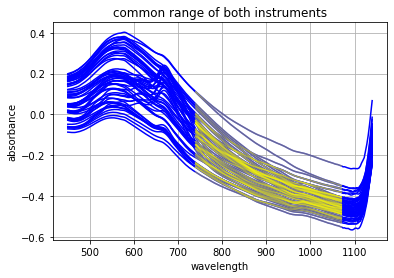

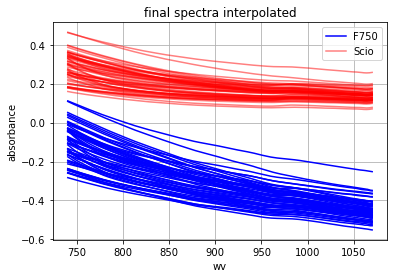

In [4]:
# interpolation



instrument_ref = "F750"
instrument_interp = "Scio"

spectra_final = {}


spectra_final[instrument_ref] = np.zeros(spectra_raw[instrument_interp].shape)

for ii in range(spectra_raw[instrument_ref].shape[0]):

    interp = sp.interpolate.interp1d(spectra_raw["wv_range_" + instrument_ref],spectra_raw[instrument_ref][ii,:], kind = 'linear')
    spectra_interp = interp(spectra_raw["wv_range_" + instrument_interp])

    spectra_final[instrument_ref][ii,:] = spectra_interp.copy()


plt.plot(spectra_raw["wv_range_" +instrument_ref],spectra_raw[instrument_ref].T, c = "blue")
plt.plot(spectra_raw["wv_range_" +instrument_interp],spectra_final[instrument_ref].T, c = "yellow", alpha = 0.4)
plt.xlabel("wavelength")
plt.ylabel("absorbance")
plt.title("common range of both instruments")
plt.grid()
plt.show()

spectra_final[instrument_interp] = spectra_raw[instrument_interp]
spectra_final["wv_range"] = spectra_raw["wv_range_" + instrument_interp]

plt.plot(spectra_final["wv_range"],spectra_final[instrument_ref][0], c = "blue", label = instrument_ref)
plt.plot(spectra_final["wv_range"],spectra_final[instrument_ref].T, c = "blue")
plt.plot(spectra_final["wv_range"],spectra_final[instrument_interp][0], c = "red", alpha = 0.5,label = instrument_interp)
plt.plot(spectra_final["wv_range"],spectra_final[instrument_interp].T, c = "red", alpha = 0.5)
plt.xlabel("wv")
plt.ylabel("absorbance")
plt.title("final spectra interpolated")
plt.legend()
plt.grid()
plt.show()


In [5]:
# reference values

y_name = 'CP'
source_name = "F750"
target_name = "Scio"


reference_values = data_pd.loc[:,["Sample", y_name]].drop_duplicates()


Xsou_all = spectra_final[source_name]
Xtar_all = spectra_final[target_name]
Y_all = Ysou = np.array(reference_values["CP"])
Y_all.shape = (Y_all.shape[0],1)



In [6]:

my_ss = sample_selection(Xsou_all, ncp = 10)
my_ss.get_xcal_pca_scores()
sou_samples = my_ss.kennard_stone(Nout = int(0.7*Xsou_all.shape[0]), use_pca_scores=True, distance_metric='mahalanobis') == 1

Xsou = Xsou_all[sou_samples,:]
Ysou = Y_all[sou_samples,:]
Xtar = Xtar_all[sou_samples,:]

Xsou_test = Xsou_all[sou_samples==False,:]
Xtar_test = Xtar_all[sou_samples==False,:]
Ytar_test = Y_all[sou_samples==False,:]



# Standard samples

In [7]:
rng = np.random.RandomState(754357)
stdsamples = rng.choice(Xsou.shape[0], 10, replace = False)

Xprimary = Xsou[stdsamples,:]
Xsecondary = Xtar[stdsamples,:]
Yprimary = Ysou[stdsamples,:]
Ysecondary = Ysou[stdsamples,:]
Xsou_cal = np.delete(Xsou, obj = stdsamples, axis = 0)
Ysou_cal = np.delete(Ysou, obj = stdsamples, axis = 0)

Xsou_cal.shape

(29, 331)

In [8]:
print("calibration \n")
print("n " , Ysou_cal.shape[0]," \n",
      "mean ", Ysou_cal.mean()," \n",
    "std " , Ysou_cal.std())

print("standards \n")
print("n " , Xprimary.shape[0]," \n")


print("test \n")
print("n " , Ytar_test.shape[0]," \n",
      "mean ", Ytar_test.mean()," \n",
    "std " , Ytar_test.std())

calibration 

n  29  
 mean  3.001034482758621  
 std  2.054470893924602
standards 

n  10  

test 

n  18  
 mean  3.122777777777778  
 std  1.9652136031924976


# PLS model building

In [9]:
xcal_pls = Xsou_cal.copy()
ycal_pls = Ysou_cal.copy()

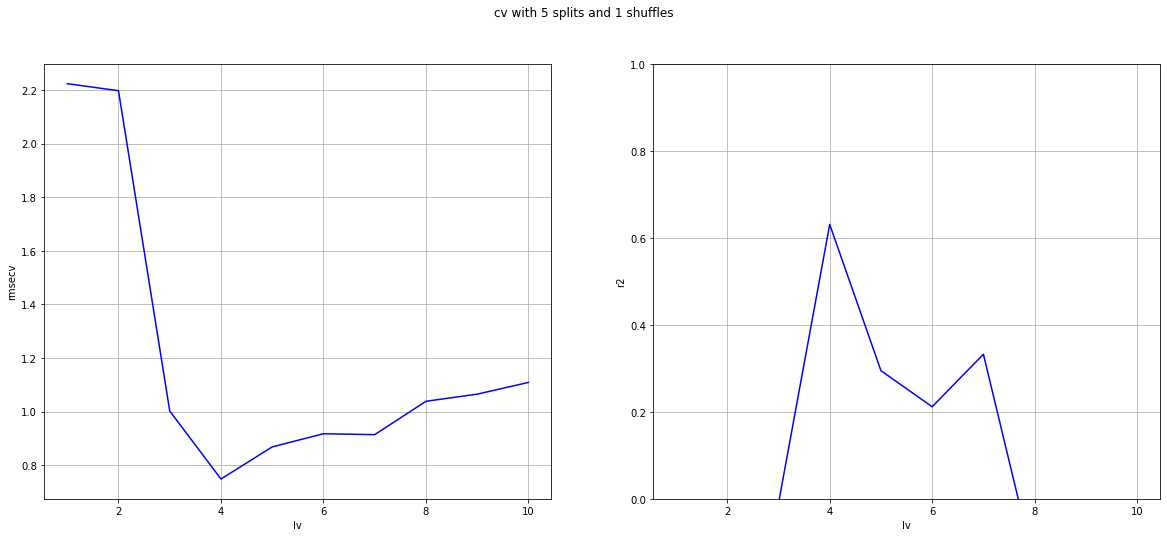

In [13]:
total_lv = 10
n_splits_cv = 5
n_shuffles = 1

parameters = {'n_components': list(range(1,total_lv+1))}
pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}


fig, axs = plt.subplots(1,2,figsize = (20,8))

for nn in range(n_shuffles):

    pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
    my_pls = PLSRegression(scale=False)
    my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
    my_pls_cv.fit(xcal_pls, ycal_pls)

    axs[0].plot(my_pls_cv.cv_results_["param_n_components"],-1*my_pls_cv.cv_results_["mean_test_rmse"], c = "blue")
    axs[1].plot(my_pls_cv.cv_results_["param_n_components"],my_pls_cv.cv_results_["mean_test_r2"], c = "blue")

axs[0].set_xlabel("lv")
axs[0].set_ylabel("rmsecv")
axs[0].grid()

axs[1].set_xlabel("lv")
axs[1].set_ylabel("r2")
axs[1].set_ylim([0,1])
axs[1].grid()


fig.suptitle("cv with {} splits and {} shuffles".format(n_splits_cv, n_shuffles))
plt.show()

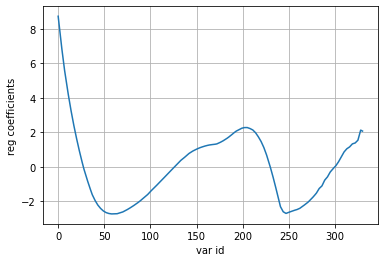

In [20]:
# choose model

chosen_lv = 4

my_pls = PLSRegression(n_components = chosen_lv,scale=False)
my_pls.fit(xcal_pls, ycal_pls)
x_mean = xcal_pls.mean(axis=0)
y_mean = ycal_pls.mean(axis=0)

# deliver model

B = my_pls.coef_
beta = y_mean - (x_mean.dot(B))

plt.plot(B)
plt.xlabel("var id")
plt.ylabel("reg coefficients")
plt.grid()
plt.show()

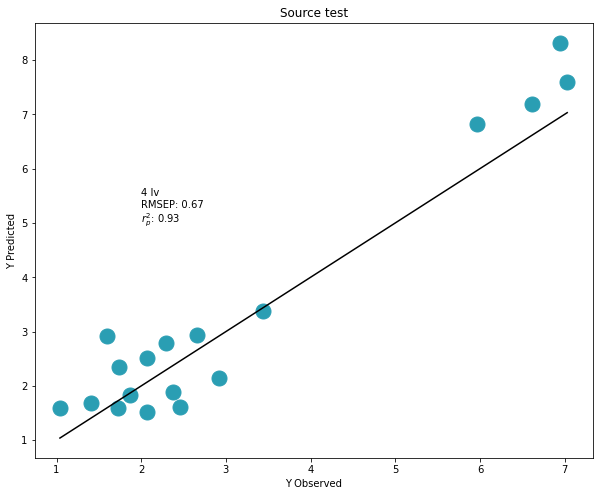

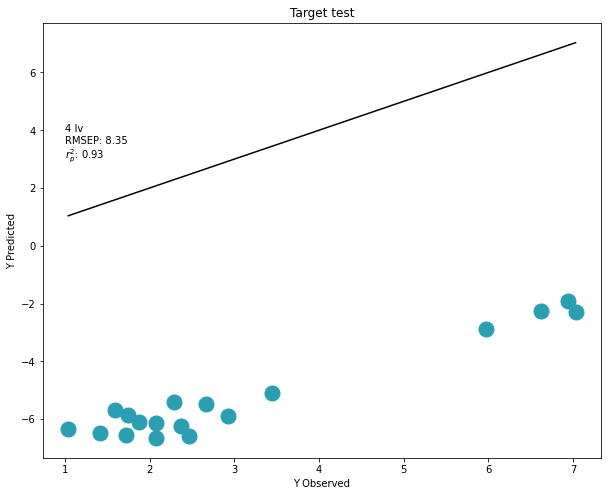

In [15]:
# use model in target domain

xsou_test = Xsou_test.copy()
xtar_test = Xtar_test.copy()
ytest_pls = Ytar_test.copy()


ytest_pls_pred = xsou_test.dot(B) + beta 


source_performance , (fig, ax_source) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Source test",
                                                    x_perf_t = 2,y_perf_t = 5, fig_width = 10,fig_height = 8)

# fig.savefig("../output/gasoline_modperf_sourceset.png")


ytest_pls_pred = xtar_test.dot(B) + beta 


target_performance , (fig, ax_target) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Target test",
                                                    x_perf_t = 1,y_perf_t = 3, fig_width = 10,fig_height = 8)
# fig.savefig("../output/gasoline_modperf_targetset.png")


# Standardization

In [16]:
F_ds,a_ds = caltransfer.ds_pc_transfer_fit(Xprimary, Xsecondary, max_ncp = Xsou.shape[1])
F_pds,a_pds = caltransfer.pds_pls_transfer_fit(Xprimary, Xsecondary, max_ncp = 1, ww = 1)
F_sst,a_sst = caltransfer.sst(Xprimary, Xsecondary, ncomp = 1)

In [17]:

Xtar_test_ds = Xtar_test.dot(F_ds) + a_ds
Xtar_test_pds = Xtar_test.dot(F_pds) + a_pds
Xtar_test_sst = Xtar_test.dot(F_sst) + a_sst


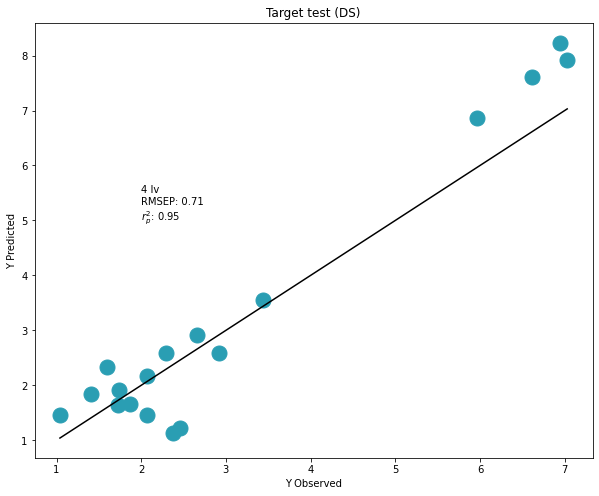

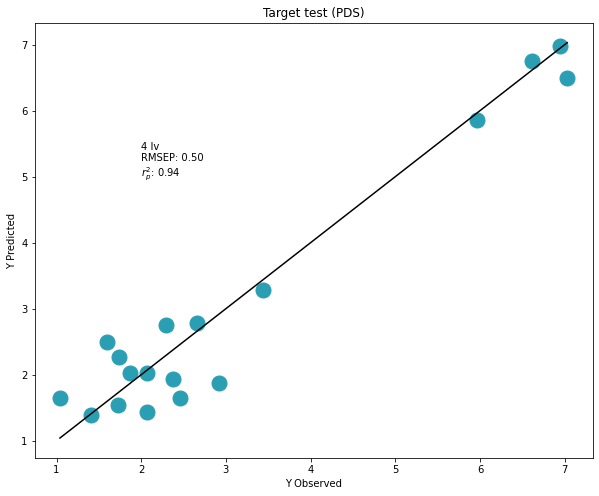

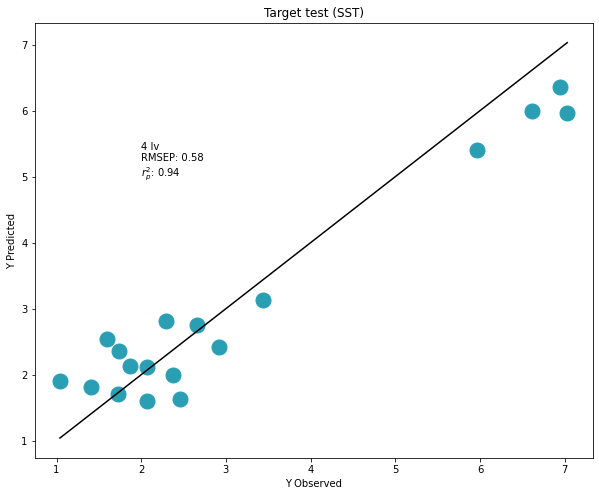

In [18]:
# use model in target domain after standardization



ytest_pls_pred = Xtar_test_ds.dot(B) + beta 


target_ds_performance , (fig, ax_ds) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Target test (DS)",
                                                    x_perf_t = 2,y_perf_t = 5, fig_width = 10,fig_height = 8)

# fig.savefig("../output/gasoline_modperf_targetds.png")


ytest_pls_pred = Xtar_test_pds.dot(B) + beta 


target_pds_performance , (fig, ax_pds) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Target test (PDS)",
                                                    x_perf_t = 2,y_perf_t = 5, fig_width = 10,fig_height = 8)

# fig.savefig("../output/gasoline_modperf_targetpds.png")


ytest_pls_pred = Xtar_test_sst.dot(B) + beta 


target_sst_performance , (fig, ax_sst) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Target test (SST)",
                                                    x_perf_t = 2,y_perf_t = 5, fig_width = 10,fig_height = 8)

# fig.savefig("../output/gasoline_modperf_targetsst.png")



# Slope and Bias correction

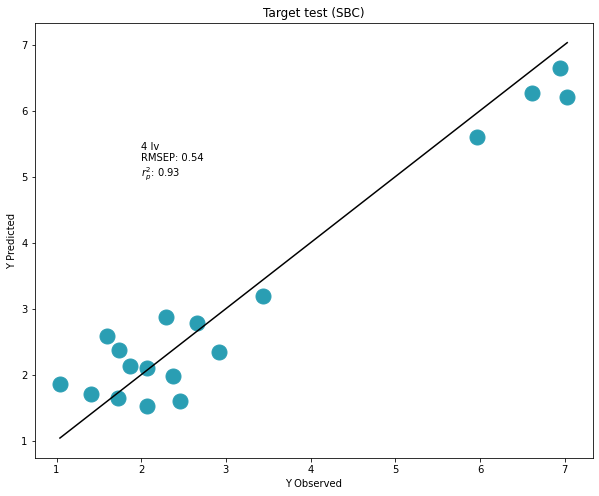

In [19]:
# SBC

xtar_test = Xtar_test.copy()
ytest_pls = Ytar_test.copy()


ytest_pls_pred_source = xtar_test.dot(B) + beta 
ysecondary_pls_pred_source = Xsecondary.dot(B) + beta 


slope, bias = caltransfer.slope_bias_correction(Yprimary, ysecondary_pls_pred_source)

ytest_pls_pred = ytest_pls_pred_source.dot(slope) + bias


target_sbc_performance , (fig, ax_sbc) = utils.get_mod_performance(ytest_pls, ytest_pls_pred,chosen_lv = chosen_lv,
                                                    property_name = "Y",
                                                    type_data = "Target test (SBC)",
                                                    x_perf_t = 2,y_perf_t = 5, fig_width = 10,fig_height = 8)



